In [1]:
import os
import requests
from bs4 import BeautifulSoup
from typing import List
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
import gradio as gr
import json

In [2]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyCv


In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### Tool

In [5]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [18]:
# There is particular dictionary structure 

tool_function = [
    {
        "name":"get_ticket_price",
        "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
        "parameters":{
            "type":"object",
            "properties":{
                "destination_city":{
                    "type":"string",
                    "description":"The city that the customer wants to travel to",
                },
            },
            "required":["destination_city"],
            "additionalProperties":False
        },
    },

    {
        "name":"book_flight",
        "description": "Book the flight ticket.",
        "parameters":{
            "type":"object",
            "properties":{
                "ticket_number":{
                    "type":"int",
                    "description":"Produced 6 digit ticket number",
                },
                "destination_city":{
                    "type":"string",
                    "description":"The city that the customer wants to travel to",
                },
                "booking_code":{
                    "type":"bool",
                    "description":"Booking code to confirm reservation",
                }
            },
            "required":["destination_city", "destination_city", "booking_code"],
            "additionalProperties":False
        },
    }
]

In [19]:
tools = [{"type":"function", "function":tool_function}]

In [8]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role":"tool",
        "content":json.dumps({"destination_city":city, "price":price}),
        "tool_call_id":message.tool_calls[0].id
    }
    return response, city

In [9]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        print(message.tool)
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content
"""
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

    
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] 
    for human, assistant in history:
        messages.append({"role":"user", "content":human})
        messages.append({"role":"assistant", "content":assistant})
    messages.append({"role":"user", "content":message})

    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_all(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    return response.choices[0].message.content 
"""

'\ndef chat(message, history):\n    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]\n    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)\n\n    if response.choices[0].finish_reason=="tool_calls":\n        message = response.choices[0].message\n        response, city = handle_tool_call(message)\n        messages.append(message)\n        messages.append(response)\n        response = openai.chat.completions.create(model=MODEL, messages=messages)\n    \n    return response.choices[0].message.content\n\n    \ndef chat(message, history):\n    messages = [{"role": "system", "content": system_message}] \n    for human, assistant in history:\n        messages.append({"role":"user", "content":human})\n        messages.append({"role":"assistant", "content":assistant})\n    messages.append({"role":"user", "content":message})\n\n    response = openai.chat.completions.create(model=MODEL, messages=mes

In [ ]:
call = chat()

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


#### Day 5

In [11]:
import base64
from io import BytesIO
from PIL import Image

In [12]:
def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",       
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

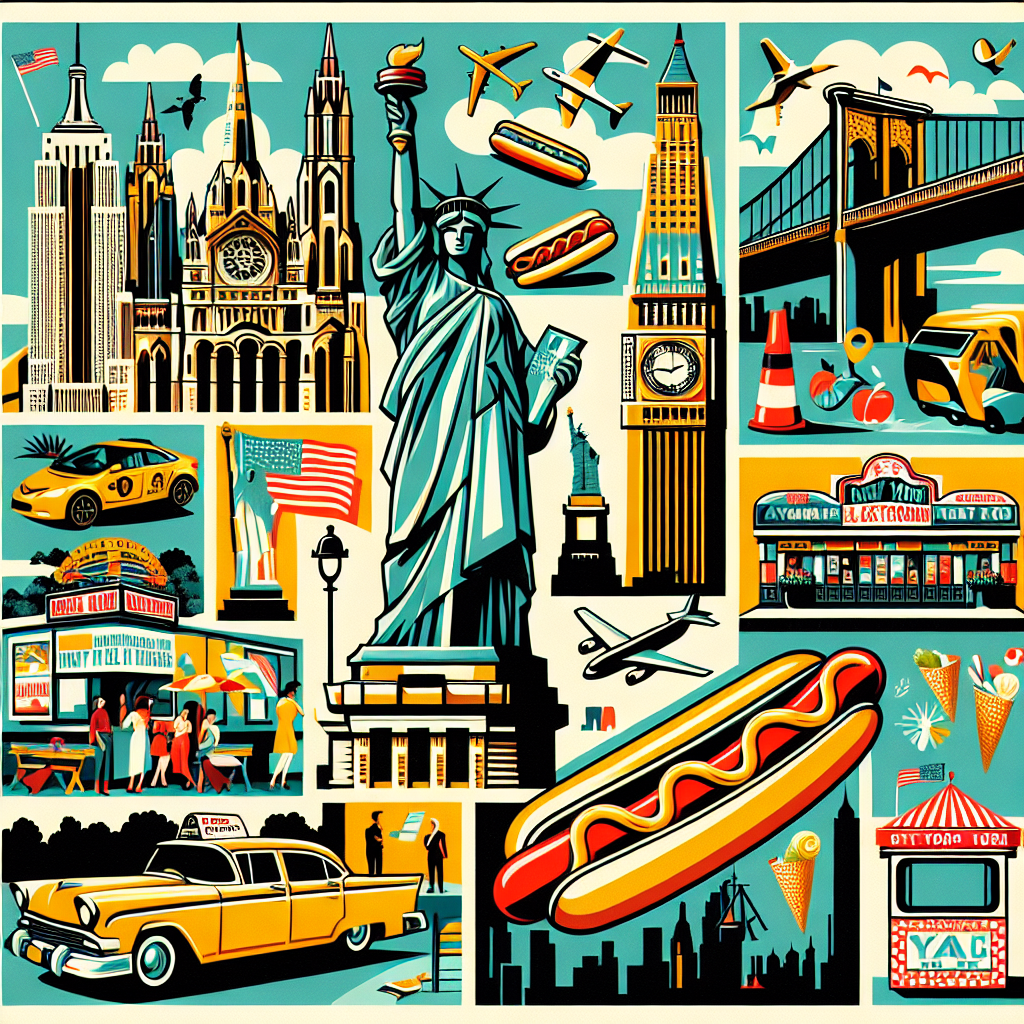

In [13]:
#image = artist("New York City")
#display(image)

In [13]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --enable-

In [14]:
from pydub import AudioSegment
from pydub.playback import play

In [15]:
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [16]:
#talker("Well, hi there")

In [ ]:
def booking(city, history):
    messages = [{"role": "system", "content": system_message}] + history 
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None


### 

In [17]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history 
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    talker(reply)

    return history,image

In [28]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant")
    with gr.Row():
        clear = gr.Button("Clear")
    
    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )

    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/tmp/tmpdjew6vz9.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.11, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/tmp/tmpgf1c4j6f.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:05.50, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for London


Input #0, wav, from '/tmp/tmpx5v1ukiz.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:03.79, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
